# 2/19/20
***
Мне снова задали вопрос о коррелированном отборе, поэтому надо с ним разобраться

In [1]:
import numpy as np
import uproot
import uproot_methods
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplhep as hep
from glob import glob

%matplotlib inline

sns.set(rc={'figure.figsize':(13,7)}, font_scale=1.7)
plt.style.use('seaborn-whitegrid')

def my_style(title='', xtitle='', ytitle='', gridstyle=':'):
    plt.grid(linestyle=gridstyle)
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)

In [2]:
import warnings
warnings.filterwarnings("ignore")

Посмотрю картинки, на которых видно коррелированный отбор

In [9]:
ebeam = 950
mom_tree_exp = uproot.open(glob(f'../../outputs/19/trees/{ebeam}*.root')[0])['pic_mom']
mom_tree_mc = uproot.open(glob(f'../../outputs/model_old_v7/trees/{ebeam}*.root')[0])['pic_mom']

In [10]:
mom_df_exp = mom_tree_exp.pandas.df()
mom_df_mc = mom_tree_mc.pandas.df()

In [11]:
p_cut = 2 * (0.0869 * ebeam - 36.53)
p0 = np.sqrt(ebeam**2 - 497.6**2)

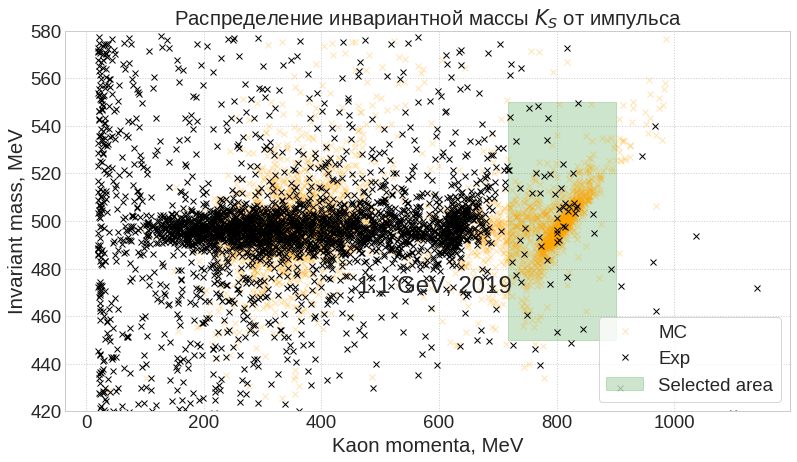

In [12]:
plt.plot(mom_df_mc.momentum, mom_df_mc.mass, 'x', label='MC', alpha=0.3, c='orange')
plt.plot(mom_df_exp.momentum, mom_df_exp.mass, 'x', label='Exp', c='black')
plt.fill_between([p0-p_cut, p0+p_cut], [450, 450], [550, 550], color='green', alpha=0.2, label='Selected area')
plt.grid(linestyle=":")
# plt.xlim(50, 350);
plt.ylim(420, 580);
plt.text(460, 470, "1.1 GeV, 2019", size=24);
plt.title('Распределение инвариантной массы $K_S$ от импульса')
plt.xlabel('Kaon momenta, MeV');
plt.ylabel('Invariant mass, MeV');
plt.legend(frameon=True);
# plt.savefig('outputs/images/7_invMass_mom_dist_19_1.1GeV.png', dpi=300)

Проверяю гипотезу о том, что фон пикуется, для этого
1. Смотрю распределение по импульсу каона, беру сайд-бенды
2. Смотрю как события из сайд-бендов ведут себя на картинке и инвариантной массой

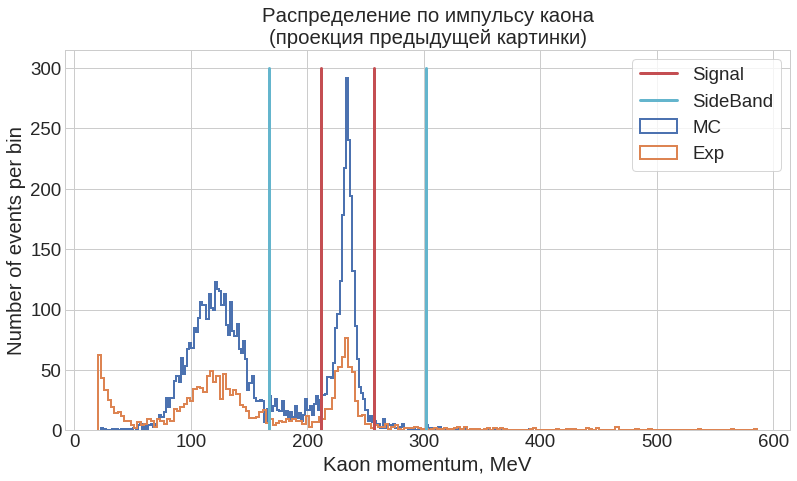

In [259]:
sideband = 3*p_cut
plt.hist(mom_df_mc.momentum, bins=200, histtype='step', lw=2, label='MC');
plt.hist(mom_df_exp.momentum, bins=200, histtype='step', lw=2, label='Exp');
plt.plot([p0-p_cut, p0-p_cut], [0, 300], c='r', lw=3)
plt.plot([p0+p_cut, p0+p_cut], [0, 300], c='r', lw=3, label='Signal')
plt.plot([p0-sideband, p0-sideband], [0, 300], c='c', lw=3)
plt.plot([p0+sideband, p0+sideband], [0, 300], c='c', lw=3, label='SideBand');
plt.legend(frameon=True)
plt.title('Распределение по импульсу каона\n(проекция предыдущей картинки)')
plt.ylabel('Number of events per bin');
plt.xlabel('Kaon momentum, MeV');
# plt.xlim(100, 500)

In [263]:
sideband_area = dict()
sideband_area['exp'] = mom_df_exp.query('abs(momentum-@p0)<@sideband&abs(momentum-@p0)>@p_cut')
sideband_area['mc'] = mom_df_mc.query('abs(momentum-@p0)<@sideband&abs(momentum-@p0)>@p_cut')

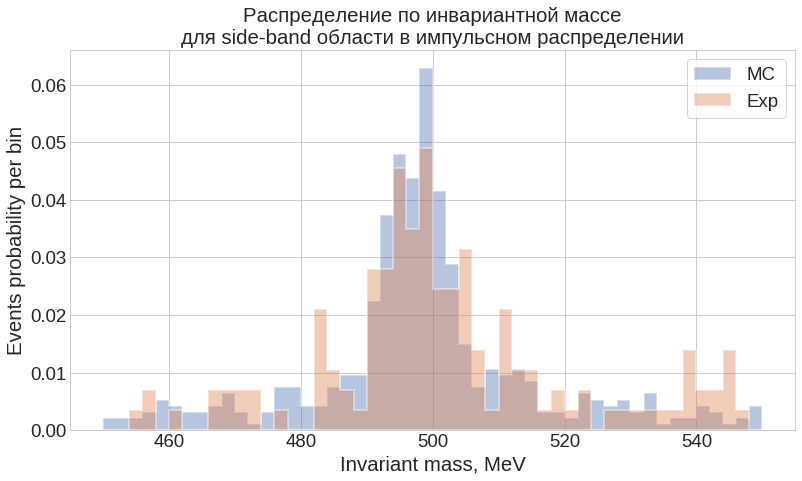

In [273]:
plt.hist( sideband_area['mc'].mass, 
         bins=50, histtype='stepfilled', lw=2, density=True, range=(450, 550), alpha=0.4, label='MC' );
plt.hist( sideband_area['exp'].mass, 
         bins=50, histtype='stepfilled', lw=2, density=True, range=(450, 550), alpha=0.4, label='Exp' );
plt.legend(frameon=True);
plt.title('Распределение по инвариантной массе\nдля side-band области в импульсном распределении')
plt.xlabel('Invariant mass, MeV');
plt.ylabel('Events probability per bin');

Видно, что в области массы $K_S$ наблюдается пик, однако этот пик также присутствует в моделировании, что говорит о том, что там находятся неотобранные мной $K_S$-мезоны, поэтому это вообще не side-bands и так делать нельзя

*Ради интереса попробую повернуть оси*

In [378]:
cov_matrix = mom_df_mc.query('abs(momentum-@p0)<@p_cut')[['momentum','mass']].cov().values
cov_matrix

array([[ 61.63748149,  20.47420831],
       [ 20.47420831, 139.67546454]])

In [379]:
vP = ( cov_matrix[0,0] )
vM = ( cov_matrix[1,1] )
covMP = cov_matrix[0,1]

phi = (1/2)*np.arcsin( covMP/(vP - vM) )

Угол поворота найден, теперь нужно повернуть координаты

In [380]:
A = np.array([[0.5, 0], [0, 1]])
R = np.array([ [np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)] ] )

In [381]:
A = mom_df_mc[['momentum', 'mass']].values.T
B = mom_df_exp[['momentum', 'mass']].values.T

In [382]:
new_df_mc = pd.DataFrame( np.matmul(R, A).T )
new_df_exp = pd.DataFrame( np.matmul(R, B).T )

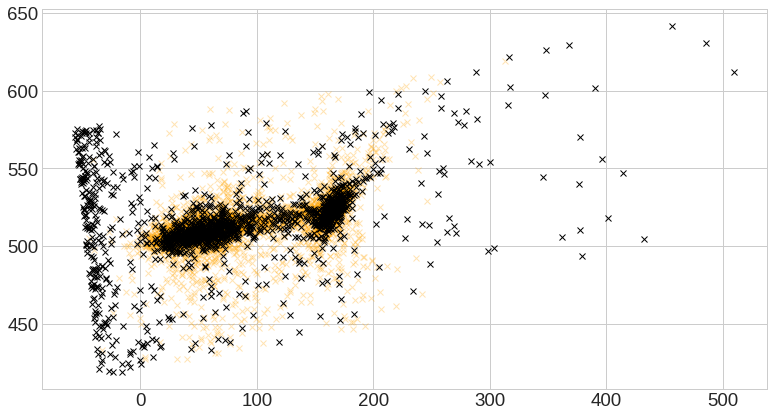

In [383]:
plt.plot(new_df_mc[0], new_df_mc[1], 'x', label='MC', alpha=0.3, c='orange')
plt.plot(new_df_exp[0], new_df_exp[1], 'x', label='Exp', c='black')

## Аппроксимация одним Гауссом

In [225]:
def fcn_tester():
    a = []
    for _ in range(500):
        data = pf.gen_toy(pf.gaussian, 5000, bound=bound, mean=497.617, sigma=5, quiet=True);
        unbinned_likelihood = pf.UnbinnedLH(pf.gaussian, data);
        minuit = iminuit.Minuit(unbinned_likelihood, mean=497.6, sigma=5);
        minuit.migrad();
        a.append( minuit.fval )
    return a

In [210]:
data = np.random.normal(497.6, 9, 7000)

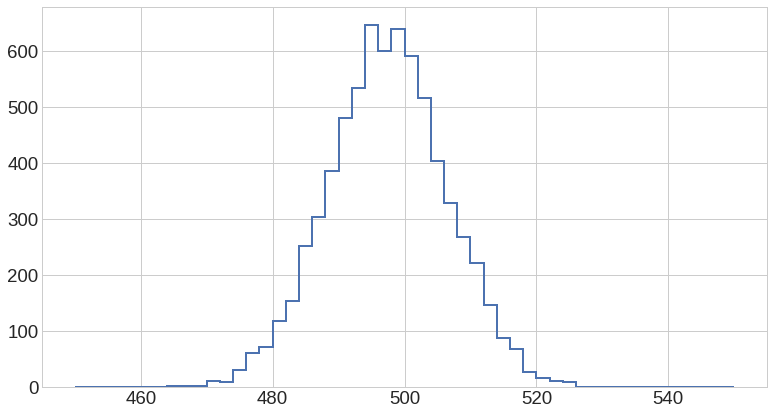

In [211]:
plt.hist(data, bins=50, range=(450, 550), histtype='step', lw=2);

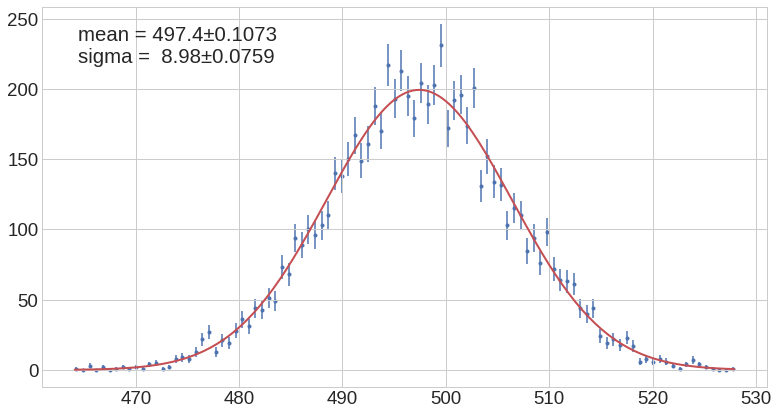

In [212]:
import probfit as pf
import iminuit
unbinned_likelihood = pf.UnbinnedLH(pf.gaussian, data)
minuit = iminuit.Minuit(unbinned_likelihood, mean=497.6, sigma=5);
minuit.migrad();
unbinned_likelihood.draw(minuit);

In [213]:
# np.random.seed(0)
bound = (497.6-40, 497.6+40);
data = pf.gen_toy(pf.gaussian, 5000, bound=bound, mean=497.617, sigma=5, quiet=True);
# plt.grid(linestyle=':');

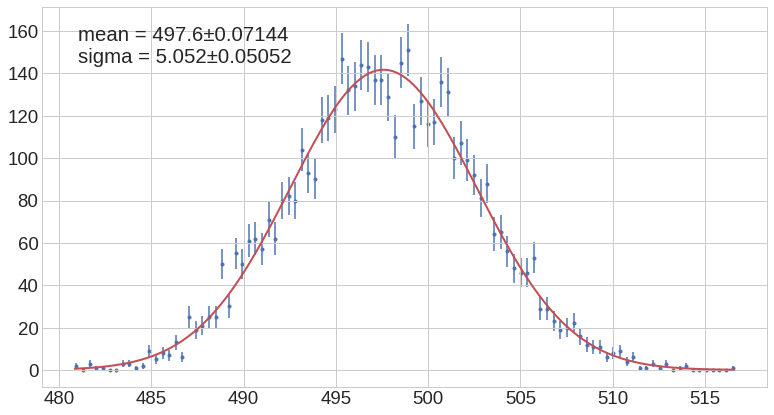

In [214]:
unbinned_likelihood = pf.UnbinnedLH(pf.gaussian, data);
minuit = iminuit.Minuit(unbinned_likelihood, mean=497.6, sigma=5);
minuit.migrad();
unbinned_likelihood.draw(minuit);

In [215]:
minuit.fval

15193.344932149601

In [219]:
a = []
for _ in range(500):
    data = pf.gen_toy(pf.gaussian, 5000, bound=bound, mean=497.617, sigma=5, quiet=True);
    unbinned_likelihood = pf.UnbinnedLH(pf.gaussian, data);
    minuit = iminuit.Minuit(unbinned_likelihood, mean=497.6, sigma=5);
    minuit.migrad();
    a.append( minuit.fval );

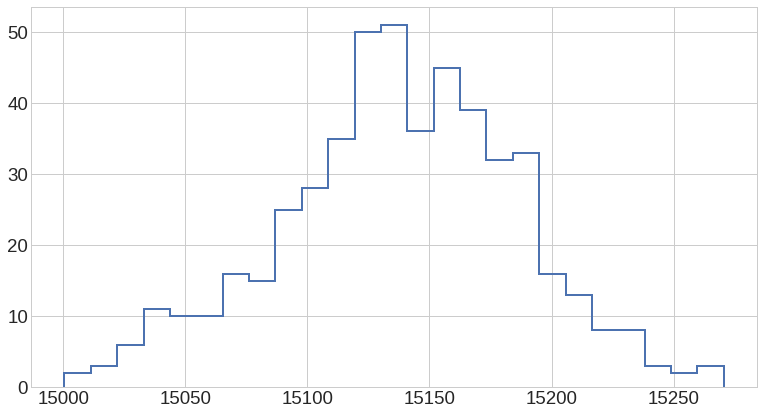

In [220]:
plt.hist(a, bins=25, histtype='step', lw=2);

Добавлю это в файл `Analysis.ipynb`

## Фит. функция  - вторая часть
____
Найду истинные пионы из распада $K_S$ в MC, привяжу их к реконструированным и отстрою инвариантную массу.

In [213]:
def select_charge_df(mc_gen, mc_rec, charge=1):
    mc_gen_plus = mc_gen.query('(simorig==310)&(simtype==211*@charge)').copy().drop(['simorig','simtype'], axis=1).\
               reset_index(level=1, drop=True)
    mc_rec_plus = mc_rec.query('tcharge==@charge')
    mc_plus = mc_rec_plus.merge(mc_gen_plus, on='entry').drop(['tcharge'],axis=1).dropna().\
                            rename({'vec_x':'rec', 'vec_y':'gen'},axis=1)
    mc_plus['diff'] = [ x.angle(y) for x,y in zip(mc_plus.rec.values, mc_plus.gen.values)]
    mc_plus = mc_plus.reset_index()
    mc_plus = mc_plus.loc[ mc_plus.groupby('entry')['diff'].idxmin() ].copy().set_index('entry')
    return mc_plus.query('diff<0.1')

def find_pions_from_ks_decay(mc):
    mc_gen = mc.pandas.df( branches=['emeas', 'simtype', 'simorig', 'simtheta', 'simphi', 'simmom'] )
    mc_gen = vector_creator(mc_gen, 'simmom', 'simtheta', 'simphi').drop(['simmom', 'simtheta', 'simphi'], axis=1)
    
    mc_rec = mc.pandas.df( branches=['nt', 'tth', 'tphi', 'tcharge', 'tptot'] ).query('nt>1').drop(['nt'], axis=1)
    mc_rec = vector_creator(mc_rec, 'tptot', 'tth', 'tphi').drop(['tptot', 'tth', 'tphi'], axis=1)
       
    return select_charge_df(mc_gen, mc_rec, 1), select_charge_df(mc_gen, mc_rec, -1)

def vector_creator(df, p='tptot', th='tth', ph='tphi'):
    df['vec'] = uproot_methods.TVector3Array.from_spherical(df[p], df[th], df[ph])
    return df

def get_df_charged(ks_table, charge=1):
    df_plus = pd.DataFrame( np.where(ks_table['charge[0]']==charge, 
        [ ks_table['kspipt[0]'], ks_table['kspith[0]'], ks_table['kspiphi[0]'] ], 
        [ ks_table['kspipt[1]'], ks_table['kspith[1]'], ks_table['kspiphi[1]'] ] ).T, index=ks_table.index, 
                  columns=['p', 'th', 'phi'] )
    return df_plus

def find_pions_from_ks_decay_corrected(mc):
    mc_gen = mc.pandas.df( branches=['emeas', 'simtype', 'simorig', 'simtheta', 'simphi', 'simmom'] )
    mc_gen = vector_creator(mc_gen, 'simmom', 'simtheta', 'simphi').drop(['simmom', 'simtheta', 'simphi'], axis=1)
    
    ks_table = mc.pandas.df(branches=['kspiphi', 'kspith', 'kspipt', 'kstype', 'ksvind'])
    charge = mc.array(branch=['tcharge'])
    for r in ks_table.iterrows():
        ks_table.at[r[0], 'charge[0]'] = charge[ r[0][0], int(r[1]['ksvind[0]']) ]
        ks_table.at[r[0], 'charge[1]'] = charge[ r[0][0], int(r[1]['ksvind[1]']) ]
    df_plus = get_df_charged(ks_table, 1)
    df_minus = get_df_charged(ks_table, -1)
    
    df_plus = vector_creator(df_plus, 'p', 'th', 'phi').drop(['p','th','phi'], axis=1).reset_index(level=1)
    df_plus['tcharge'] = 1
    
    df_minus = vector_creator(df_minus, 'p', 'th', 'phi').drop(['p','th','phi'], axis=1).reset_index(level=1)
    df_minus['tcharge'] = -1        

    return select_charge_df(mc_gen, df_plus, 1), select_charge_df(mc_gen, df_minus, -1)

In [207]:
mc = uproot.open('/store17/petrov/data/kskl_sim/tr_ph_run004900.root')['tr_ph'] #004880 550 MeV 004910 935 MeV

In [214]:
mc_plus, mc_minus = find_pions_from_ks_decay_corrected(mc) #corrected pions
# mc_plus, mc_minus = find_pions_from_ks_decay(mc) #obvious pions

In [215]:
mc_minus.head()

,subentry,rec,emeas,gen,diff
entry,,,,,
0,0,"TVector3(61.062, -327.41, 256.39)",812.5,"TVector3(61.014, -325.2, 253.98)",0.001626
2,0,"TVector3(-206.53, -44.487, 406.36)",812.5,"TVector3(-159.09, -29.887, 334.14)",0.030706
9,0,"TVector3(38.273, 57.454, -41.277)",812.5,"TVector3(38.235, 57.604, -41.229)",0.001852
11,0,"TVector3(514.95, -408.81, 108.55)",812.5,"TVector3(478.7, -382.79, 97.449)",0.006889
13,0,"TVector3(-206.83, 252.08, 82.469)",812.5,"TVector3(-211.12, 258.04, 83.564)",0.002524


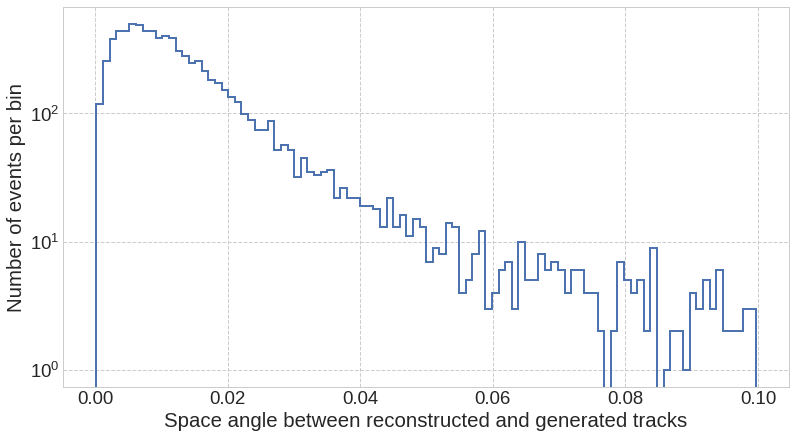

In [216]:
plt.hist( mc_plus['diff'], bins=100, histtype='step', lw=2 );
plt.yscale('log')
my_style('','Space angle between reconstructed and generated tracks', 'Number of events per bin', '--')

In [217]:
mc_minus.head()

,subentry,rec,emeas,gen,diff
entry,,,,,
0,0,"TVector3(61.062, -327.41, 256.39)",812.5,"TVector3(61.014, -325.2, 253.98)",0.001626
2,0,"TVector3(-206.53, -44.487, 406.36)",812.5,"TVector3(-159.09, -29.887, 334.14)",0.030706
9,0,"TVector3(38.273, 57.454, -41.277)",812.5,"TVector3(38.235, 57.604, -41.229)",0.001852
11,0,"TVector3(514.95, -408.81, 108.55)",812.5,"TVector3(478.7, -382.79, 97.449)",0.006889
13,0,"TVector3(-206.83, 252.08, 82.469)",812.5,"TVector3(-211.12, 258.04, 83.564)",0.002524


In [218]:
def build_decay(mc_plus, mc_minus, merge_field='rec'):
    mP = mc_plus[[merge_field]].rename({merge_field : 'plus'},axis=1)
    mM = mc_minus[[merge_field]].rename({merge_field : 'minus'},axis=1)
    
    merged_table = mP.merge(mM, on='entry')
    merged_table['angle'] = [ x.angle(y) for x,y in zip(merged_table['plus'].values, \
                                                        merged_table['minus'].values)]
    return merged_table

In [219]:
merged_table_rec = build_decay(mc_plus, mc_minus, 'rec')
merged_table_gen = build_decay(mc_plus, mc_minus, 'gen')

In [220]:
merged_table_rec.head()

,plus,minus,angle
entry,,,
0,"TVector3(-119.01, -242.42, -115.99)","TVector3(61.062, -327.41, 256.39)",1.220744
2,"TVector3(118.66, 93.588, -0.22583)","TVector3(-206.53, -44.487, 406.36)",1.999341
9,"TVector3(32.935, 320.18, 482.97)","TVector3(38.273, 57.454, -41.277)",1.576785
11,"TVector3(-44.037, -78.896, -57.273)","TVector3(514.95, -408.81, 108.55)",1.523650
13,"TVector3(-397.41, -110.65, 46.446)","TVector3(-206.83, 252.08, 82.469)",1.141367


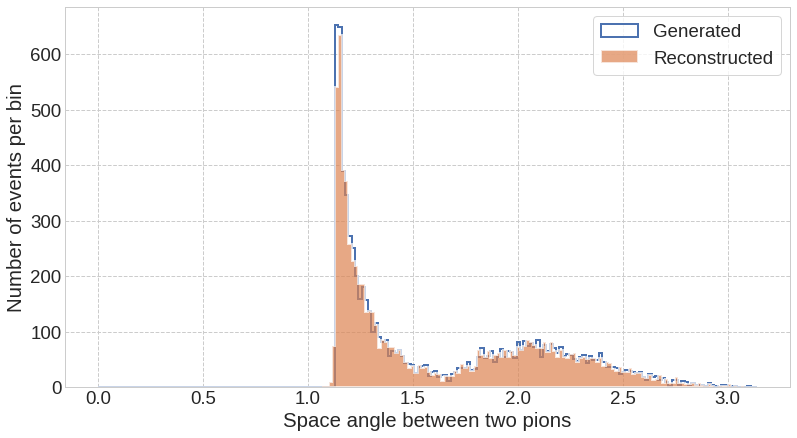

In [221]:
plt.hist( merged_table_gen['angle'], bins=200, histtype='step', lw=2, range=(0,np.pi), label='Generated' );
plt.hist( merged_table_rec['angle'], bins=200, histtype='stepfilled', lw=2, range=(0,np.pi), 
         alpha=0.7, label='Reconstructed' );
plt.legend(frameon=True)
my_style('','Space angle between two pions', 'Number of events per bin', '--')

In [222]:
def vector3_to_vector4( series, mass ):
    coords = np.array(list( map( lambda x: np.array( [x.x, x.y, x.z] ) , series ) ) )
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
    return uproot_methods.TLorentzVectorArray.from_xyzm(x, y, z, mass)
def get_mass_table(df):
    mPi = 139.6
    df = df.copy()
    df['M'] = ( vector3_to_vector4( df.plus, mPi ) + vector3_to_vector4( df.minus, mPi ) ).mass
    return df

In [223]:
vec4_table_rec = get_mass_table(merged_table_rec)
vec4_table_gen = get_mass_table(merged_table_gen)

In [224]:
vec4_table_rec.head()

,plus,minus,angle,M
entry,,,,
0,"TVector3(-119.01, -242.42, -115.99)","TVector3(61.062, -327.41, 256.39)",1.220744,492.403172
2,"TVector3(118.66, 93.588, -0.22583)","TVector3(-206.53, -44.487, 406.36)",1.999341,541.770914
9,"TVector3(32.935, 320.18, 482.97)","TVector3(38.273, 57.454, -41.277)",1.576785,481.549379
11,"TVector3(-44.037, -78.896, -57.273)","TVector3(514.95, -408.81, 108.55)",1.523650,521.298457
13,"TVector3(-397.41, -110.65, 46.446)","TVector3(-206.83, 252.08, 82.469)",1.141367,491.628565


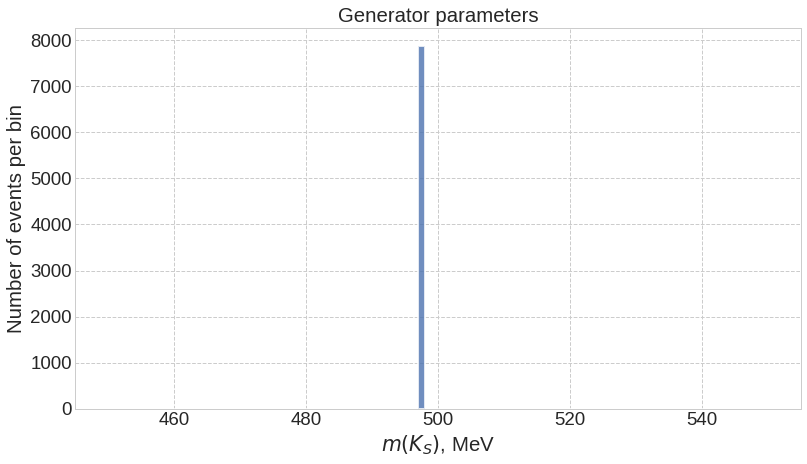

In [225]:
m = vec4_table_gen
plt.hist(m.M, bins=100, range=(450, 550), histtype='stepfilled', alpha=0.8, lw=2);
my_style('Generator parameters', '$m(K_S)$, MeV', 'Number of events per bin', '--');
# plt.savefig('outputs/images/7_gen_K.png', dpi=200)

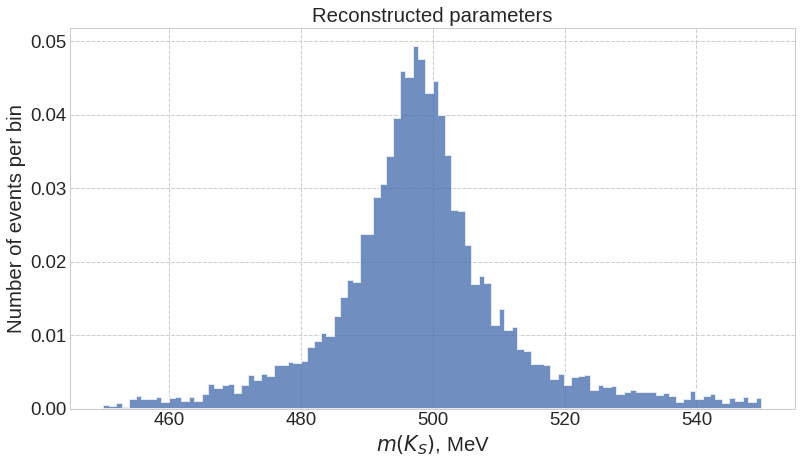

In [226]:
m = vec4_table_rec
plt.hist(m.M, bins=100, range=(450, 550), histtype='stepfilled', alpha=0.8, lw=2, density=True);
my_style('Reconstructed parameters', '$m(K_S)$, MeV', 'Number of events per bin', '--')
# plt.savefig('outputs/images/7_rec_K.png', dpi=200)

Постарался и выделил массу KS из привязанных к генератору пионов.

Теперь отфитирую эту штуку двумя гауссами

In [227]:
import iminuit
import probfit as pf

In [228]:
#гаусс + гаусс
def gauss2(x, mu, mu2, sigma1, sigma2, f):
    return f*pf.gaussian(x, mu, sigma1) + (1-f)*pf.gaussian(x, mu2, sigma2)
def const(x):
    return 1

mass_bound=(470,530)
norm_sig = pf.rename( pf.Normalized( gauss2, mass_bound ), ['x', 'M1','M2', 'S1', 'S2', 'f'] )
# norm_bkg = pf.rename( pf.Normalized( gauss, mass_bound ), ['x', 'M1', 'S2'] )

ext_sig = pf.Extended(norm_sig, extname='N1')
# ext_bkg = pf.Extended(norm_bkg, extname='N2')

pdf = ext_sig#pf.AddPdf(ext_sig, ext_bkg)

limits = {
    "limit_M1": [497, 498],
    "limit_S1": [1, 15],
    "limit_N1": [1000, 100000],
    "limit_M2": [490, 500],
    "limit_S2": [3, 25],
#     "limit_N2": [0, 7000],
    "limit_f": [0, 1],
}
pf.describe(pdf)

['x', 'M1', 'M2', 'S1', 'S2', 'f', 'N1']

In [229]:
def fitter(dic, nbins):
    
    likelihood = pf.BinnedChi2(pdf, dic, bins=nbins, bound=mass_bound)
#     likelihood = pf.UnbinnedLH(pdf, dic, extended=True, extended_bound=mass_bound)
    
    initial_par_values = {"M1": 497.6, "S1": 4.26, "N1": 7000, "S2":17,"M2": 497.6, 'f':0.5}# "N2": 1,  
    mt = iminuit.Minuit(likelihood, **initial_par_values, **limits, pedantic=False)
    mt.migrad();
    
    likelihood.draw(minuit=mt)#, bins=nbins, bound=mass_bound)
    return mt, likelihood

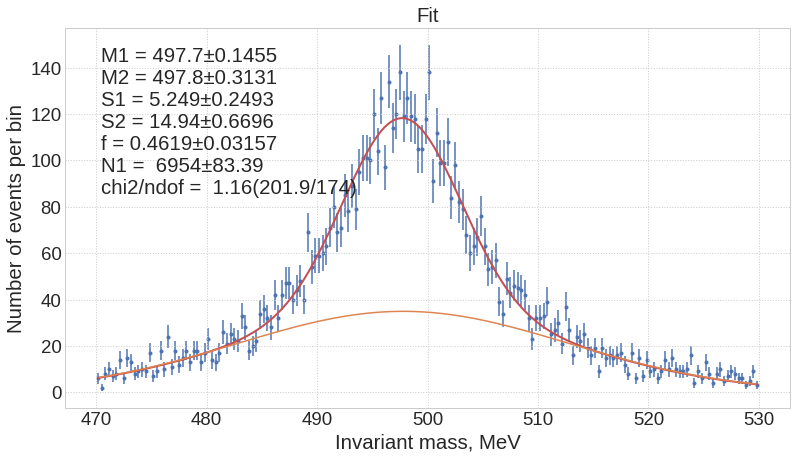

In [230]:
nbins = 180
mt, lk = fitter(m.M.values, nbins)
vals = mt.values.values()
vals[-1] *= (1-vals[-2])*(mass_bound[1]-mass_bound[0])/nbins
vals[-2] = 0
pf.draw_pdf(pdf, arg=vals, bound=mass_bound);
my_style('Fit', 'Invariant mass, MeV', 'Number of events per bin')

In [ ]:
4 15 0.7 | 4.1 14.3 0.69
6 19 0.48 | 5.5 16 0.23

In [194]:
mt.matrix(correlation=True)

--------------------------------------------------
|    |     M1     M2     S1     S2      f     N1 |
--------------------------------------------------
| M1 |  1.000 -0.219  0.071  0.051  0.043 -0.000 |
| M2 | -0.219  1.000 -0.058 -0.124 -0.059 -0.000 |
| S1 |  0.071 -0.058  1.000  0.644  0.745 -0.000 |
| S2 |  0.051 -0.124  0.644  1.000  0.782 -0.000 |
|  f |  0.043 -0.059  0.745  0.782  1.000 -0.000 |
| N1 | -0.000 -0.000 -0.000 -0.000 -0.000  1.000 |
--------------------------------------------------

# 2/27-28/20
___
Метод сайд-бендов не прокатывает, так как в них есть сигнал, поэтому ищу распределение нефизического фона

In [47]:
it = uproot.pandas.iterate('../../outputs/others/trees/*.root', treepath='pic_mom')

In [48]:
unph_bkg = pd.concat([i for i in it], ignore_index=True)

In [49]:
unph_bkg

,align,momentum,mass,passed
0,0.999892,418.163818,3.488998,False
1,0.992468,627.972290,40.252934,False
2,0.999968,471.809113,4.114306,False
3,0.999943,490.961884,15.202196,False
4,0.999997,482.764221,15.375327,False
...,...,...,...,...
1424,0.982825,61.044605,421.889160,False
1425,0.999975,36.624336,543.150757,False
1426,-0.985567,37.716602,498.424438,False
1427,0.815877,20.443487,534.720520,False


In [50]:
unph_bkg = unph_bkg.query('align>0.8')

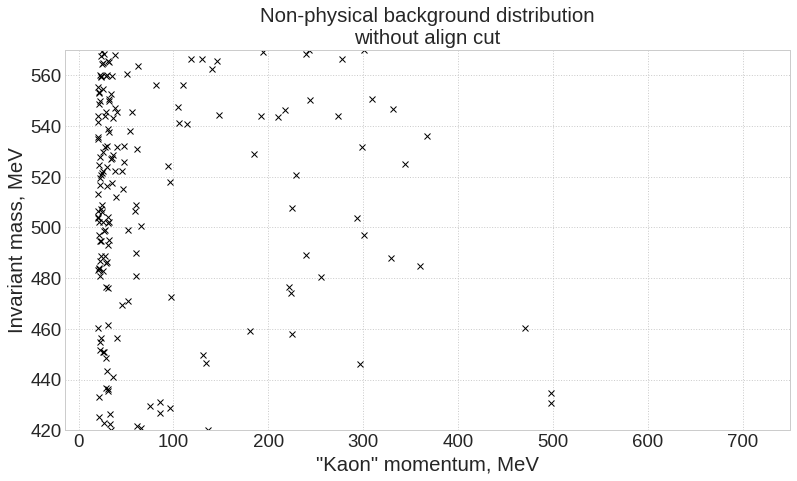

In [51]:
plt.plot(unph_bkg.momentum, unph_bkg.mass, 'x', label='Exp', c='black')
plt.ylim(420, 570);
plt.grid(linestyle=":");
plt.title('Non-physical background distribution\nwithout align cut');
# plt.text(500, 530, "$E_{beam}$ = 490 MeV\nRHO2013,18\nL = 100+100 nb")
plt.xlabel('"Kaon" momentum, MeV');
plt.ylabel('Invariant mass, MeV');
# plt.savefig('outputs/images/7_nonphys_bkg.png', dpi=200)

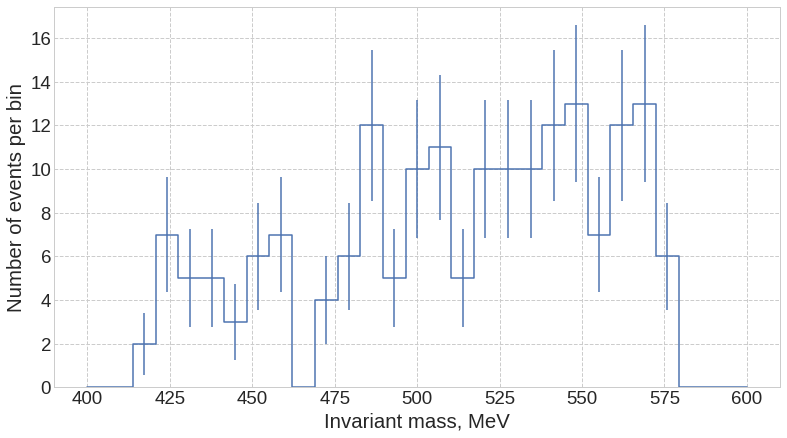

In [167]:
hist, bins = np.histogram(unph_bkg.query('momentum>00').mass, bins=np.linspace(400, 600, 30));
hep.histplot(hist, bins, yerr=True);
plt.ylabel('Number of events per bin');
plt.grid(linestyle='--')
plt.xlabel('Invariant mass, MeV');

In [139]:
import probfit as pf
from iminuit import Minuit

In [122]:
def line(x, c):
    return c

chi2 = pf.BinnedChi2(line, unph_bkg.mass, bound=(430, 520), bins=20)

ValueError: some bins are too small to do a chi2 fit. change your range

In [110]:
m = Minuit(chi2)
m.migrad()

------------------------------------------------------------------
| FCN = 17.46                   |      Ncalls=13 (13 total)      |
| EDM = 3.54E-17 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | c    |   1.25    |   0.12    |            |            |         |         |       |
------------------------------------------------------------------------------------------

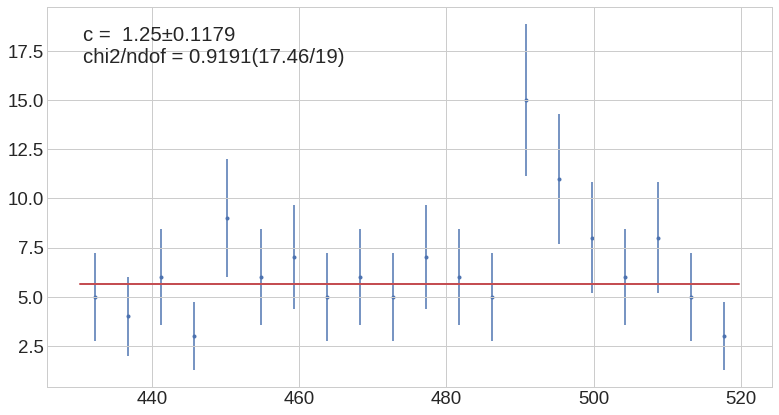

In [111]:
chi2.draw(m);

## Физический фон
____
Раз уж я этим занялся, то посмотрю на распределение физического фона для моих событий

Для этого я намоделировал 100 000 событий на мультиадронном генераторе на энергии 1.9 ГэВ, а потом нашёл кучу уже сгенерированных файлов на [Cmd3Off](https://cmd.inp.nsk.su/~cmd3off/) по 300 000 событий

In [202]:
ebeams = [749.55, 825.05, 950.00, 1003.31]
ebeam = ebeams[0]
mh_tree = uproot.open(glob(f"../../outputs/others/multihadrons/{ebeam}*.root")[0])['pic_mom']

In [203]:
mh = mh_tree.pandas.df(flatten=False).query('align>0.8')

In [204]:
def simtypes_to_process(st):
    st = st.copy()
    parts_dict = {111:'$\pi^0$', 211:'$\pi^+$', -211: '$\pi^-$', 321: '$K^+$', -321: '$K^-$', 310:'$K_S$', 130:'$K_L$', \
                  2212:'$p^+$', -2212:'$p^-$', 221:'$\eta$'}
    num_particles = list(map(lambda x: ''.join(list(map(lambda y: parts_dict[y], x))) , st)) 
    return num_particles

In [205]:
mh['process_type'] = simtypes_to_process(mh['simtypes'])
mh['is_kskl'] = (mh['process_type'] == '$K_L$$K_S$')

In [206]:
mh.head()

,align,momentum,mass,passed,simtypes,process_type,is_kskl
entry,,,,,,,
0,0.990368,215.968521,455.369843,False,"[211.0, 310.0, -321.0]",$\pi^+$$K_S$$K^-$,False
2,0.999819,447.432587,488.781128,False,"[-211.0, 310.0, 321.0]",$\pi^-$$K_S$$K^+$,False
3,0.995710,274.802551,489.325653,False,"[130.0, 310.0]",$K_L$$K_S$,True
4,0.999980,553.273499,496.031067,True,"[130.0, 310.0]",$K_L$$K_S$,True
5,0.999963,549.716309,494.561829,True,"[130.0, 310.0]",$K_L$$K_S$,True


Составлю некоторый рейтинг процессов, которые пытаются пролезть

In [207]:
mh.groupby('process_type').agg({'momentum':'count'}).sort_values(by='momentum', ascending=False)

,momentum
process_type,
$K_L$$K_S$,813
$\pi^+$$K_S$$K^-$,694
$\pi^-$$K_S$$K^+$,645
$\pi^+$$\pi^0$$\pi^0$$\pi^-$,34
$K_S$$K_L$$\pi^+$$\pi^-$,33
$\pi^+$$\pi^+$$\pi^-$$\pi^-$,23
$K_L$$K_S$$\pi^0$$\pi^0$,12
$K_S$$K_S$$\pi^+$$\pi^-$,9
$K^+$$K^-$,5


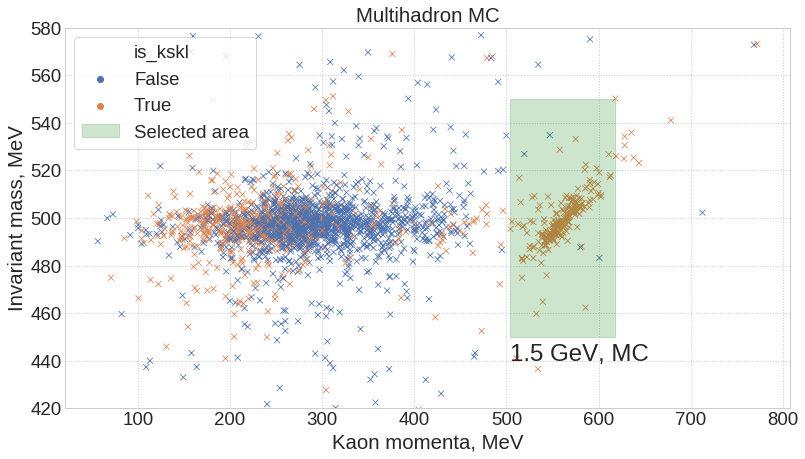

In [208]:
p_cut = 2 * (0.0869 * ebeam - 36.53)
p0 = np.sqrt(ebeam**2 - 497.6**2)

sns.scatterplot(data=mh, x='momentum', y='mass', hue='is_kskl', marker="x", legend='brief')
plt.fill_between([p0-p_cut, p0+p_cut], [450, 450], [550, 550], color='green', alpha=0.2, label='Selected area')
plt.grid(linestyle=":")
# plt.xlim(50, 350);
plt.ylim(420, 580);
plt.text(p0-p_cut, 440, f"{ebeam*0.002:.1f} GeV, MC", size=24);
plt.title('Multihadron MC')
plt.xlabel('Kaon momenta, MeV');
plt.ylabel('Invariant mass, MeV');
plt.legend(frameon=True, loc='upper left');
# plt.savefig('outputs/images/7_invMass_mom_dist_19_1.1GeV.png', dpi=300)

Нужно отметить, что событий распределённых равномерно по массе и близко к нулю по импульсу в физическом моделировании нет

Ну и финальная картинка: распределение по инвариантной массе

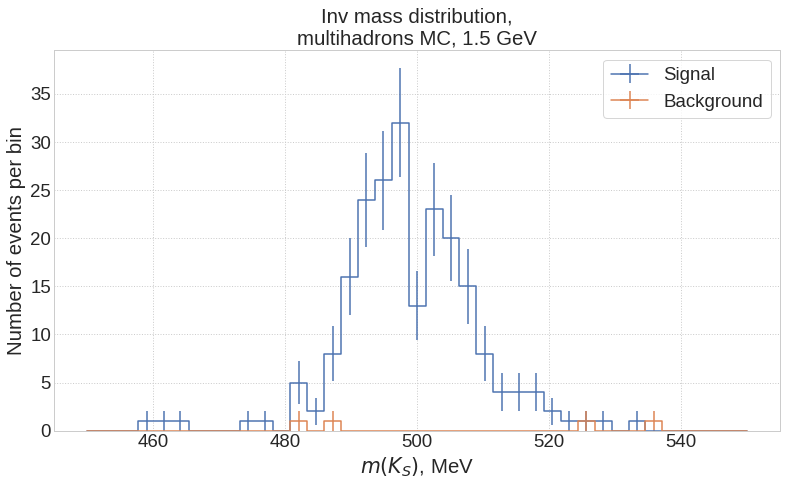

In [209]:
bins = np.linspace(450, 550, 40)
h1, _ = np.histogram(mh.query('is_kskl==True&passed').mass, bins=bins)
h2, _ = np.histogram(mh.query('is_kskl==False&passed').mass, bins=bins)

hep.histplot([h1, h2], bins=bins, stack=False, yerr=True, label=['Signal',"Background"])
my_style(f'Inv mass distribution,\nmultihadrons MC, {ebeam*0.002:.1f} GeV', \
         '$m(K_S)$, MeV', "Number of events per bin", ':')
plt.legend(frameon=True)

Посмотрю, есть ли в моём фоне космика

In [3]:
cosmic_tree = uproot.open("../../outputs/others/cosmic.root")['pic_mom']

In [4]:
cosmic_df = cosmic_tree.pandas.df(flatten=False)

In [6]:
len(cosmic_df)

0

Видно, что космика даже не пытается показаться

In [7]:
ee_tree = uproot.open("../../outputs/others/ee_1.9.root")['pic_mom']
ee_df = cosmic_tree.pandas.df(flatten=False)

In [13]:
len(ee_df)

0

$e^+e^-$ у меня тоже нету

$K^+K^-$ тоже проверил, нету